In [ ]:
!uv pip install beaut...

In [ ]:
import logging
import requests 
import pandas as pd
from bs4 import BeautifulSoup

from utils import clean_name

URL = "https://www.ysu.am/faculty/516/staff" # math mech
BASE_URL = "https://www.ysu.am"
MAIN_HTML_FILE = "math_mech_staff.html"


logger = logging.getLogger("ysu")

logging.basicConfig(
    level=logging.INFO,	
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    handlers=[
        logging.FileHandler("ysu.log"),
        logging.StreamHandler(),  # Output to console
    ]
) 

logger.info(" ")
logger.debug("Logging is set up.")

2025-08-01 19:30:37 - ysu - INFO -  


In [3]:
logger.info(f"Working for {URL}")

response = requests.get(URL)

response.raise_for_status()

logger.debug("\tGot the response")

2025-08-01 19:30:38 - ysu - INFO - Working for https://www.ysu.am/faculty/516/staff


In [ ]:
with open(MAIN_HTML_FILE, "w") as file:
    file.write(response.text)

logger.info(f"Response saved to {MAIN_HTML_FILE}")

2025-08-01 19:30:40 - ysu - INFO - Response saved to math_mech_staff.html


In [5]:
soup = BeautifulSoup(response.text, "html.parser")

print(soup.prettify())

<!DOCTYPE html>
<html dir="ltr" lang="hy" prefix="og: https://ogp.me/ns#">
 <head>
  <meta charset="utf-8"/>
  <script async="" src="https://www.googletagmanager.com/gtag/js?id=UA-44601360-1">
  </script>
  <script>
   window.dataLayer = window.dataLayer || [];function gtag(){dataLayer.push(arguments)};gtag("js", new Date());gtag("set", "developer_id.dMDhkMT", true);gtag("config", "UA-44601360-1", {"groups":"default","anonymize_ip":true,"page_placeholder":"PLACEHOLDER_page_path"});
  </script>
  <link href="https://www.ysu.am/faculty/516/staff" rel="canonical"/>
  <meta content="width" name="MobileOptimized"/>
  <meta content="true" name="HandheldFriendly"/>
  <meta content="width=device-width, initial-scale=1, shrink-to-fit=no" name="viewport"/>
  <style>
   .item-with-image-1::before { background-image: url('/sites/default/files/styles/tablet_full_width/public/banners/%D5%8D%D4%B9%D4%B5%D5%84%20%D5%A2%D5%A1%D5%B6%D5%A5%D6%80.png?itok=Qc9AWlkJ')}  .item-with-image-2::before { backgrou

In [6]:
staff_grid_class = "col-6 col-md-3 views-row"

staff = soup.find_all("div", class_=staff_grid_class)
logger.info(f"Found {len(staff)} staff members.")

2025-08-01 19:30:40 - ysu - INFO - Found 108 staff members.


In [ ]:
staff_info = []

for st in staff:
    # -------------- href ------------------
    body_card_class = "user-card-body position-relative"
    st_div = st.find("div", class_=body_card_class)
    
    href = st_div.a["href"]
    
    # -------------- Full name ------------------
    name_dirty = st_div.select(".user-full-name")[0].text
    name = clean_name(name_dirty)
    
    # -------------- Position -------------------
    position = st.select(".field--name-field-user-intranet-position")[0].text
    
    staff_info.append({
        "name": name, 
        "position": position,
        "link": href 
    })
 

In [8]:
df = pd.DataFrame(staff_info)

assert df.isna().sum().sum() == 0, "df contains NAs"

logger.info(f"Got poisiton, name, url for {len(df)} workers")

2025-08-01 19:30:40 - ysu - INFO - Got poisiton, name, url for 108 workers


In [9]:
df.to_csv("math_mech_staff.csv", index=False)

<Axes: xlabel='position'>

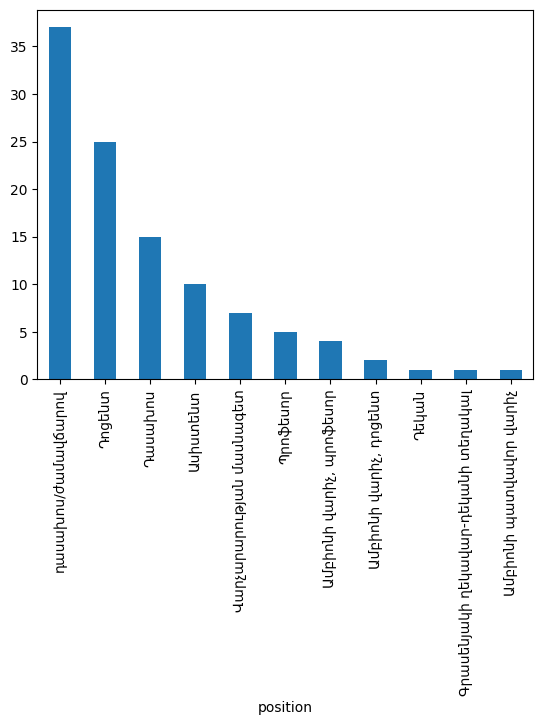

In [8]:
df["position"].value_counts().plot(kind="bar")

# Per person

In [ ]:
from pathlib import Path

PER_PERSON_FOLDER = Path("htmls_per_person")

PER_PERSON_FOLDER.mkdir(exist_ok=True)


In [ ]:
def save_html_per_person(index, row):
    file_name = f"{index}_{row['name']}"
    link = row["link"]
    
    response = requests.get(BASE_URL + link)
    response.raise_for_status()
    
    html_file = PER_PERSON_FOLDER / f"{file_name}.html"
    
    with open(html_file, "w") as file:
        file.write(response.text)



In [ ]:
from tqdm import tqdm

for index, row in tqdm(df.iterrows(), total=len(df)):
    
    save_html_per_person(link, name)
    # logger.info(f"Saving HTML for {name} at {link}")
    
    # try:
    # 	
    # except Exception as e:
    # 	logger.error(f"Failed to save HTML for {name}: {e}")

  6%|▋         | 7/108 [00:11<02:44,  1.62s/it]


KeyboardInterrupt: 

In [ ]:
from joblib import Parallel, delayed

Parallel(n_jobs=4)( # -1 = all
    delayed(save_html_per_person)(i, row) for i, row in df.iterrows()
)


In [32]:
# listdir
import os

STAFF_PATH = os.listdir(PER_PERSON_FOLDER)

In [ ]:
def get_chair_and_year(file_path):
    html_path = PER_PERSON_FOLDER / file_path
    
    with open(html_path) as file:
        html = file.read()
        
    soup = BeautifulSoup(html, "html.parser")
    
    personal_info = soup.select(".personal-information")
    year = personal_info[0].select(".field__item")[0].text
    
    if file_path.startswith("0_"):
        chair = "NA"
    else:
        chair = soup.select(".field--name-field-in-structure .field__item")[1].text
    
    return year, chair

In [77]:
df = pd.read_csv("math_mech_staff.csv")

In [78]:
fails = []
for file_path in tqdm(STAFF_PATH):
    ind = file_path.split("_")[0]
    ind = int(ind)
    
    try:
        year, chair = get_chair_and_year(file_path)
    except Exception as e:
        fails.append((ind, file_path, e))

    df.loc[ind, "year"] = year
    df.loc[ind, "chair"] = chair    

100%|██████████| 108/108 [00:16<00:00,  6.66it/s]


In [79]:
fails

[(70,
  '70_Նիկոլայ Վյաչեսլավի Կարպով.html',
  IndexError('list index out of range')),
 (80,
  '80_Վահրամ Թորգոմի Նալչաջյան.html',
  IndexError('list index out of range'))]

In [80]:
rows_to_frow = [70, 80]

df.drop(index=rows_to_frow, inplace=True)

In [81]:
df["chair_included"] = df["chair"].str.contains("ամբիոն")

In [82]:
df_chair = df[df["chair_included"]]

In [74]:
df = df[~df["chair_included"]]

In [ ]:
df_chair["age"] = 2025 - df["year"].astype("int")

In [89]:
df_chair.age.describe()

count    97.000000
mean     46.309278
std      16.888335
min      24.000000
25%      31.000000
50%      42.000000
75%      63.000000
max      79.000000
Name: age, dtype: float64

In [85]:
df_chair.chair.value_counts()

chair
Հավանականությունների տեսության և մաթեմատիկական վիճակագրության ամբիոն    28
Ակտուարական և ֆինանսական մաթեմատիկայի ամբիոն                            25
Ֆունկցիաների տեսության և դիֆերենցիալ հավասարումների ամբիոն              21
Հանրահաշվի և երկրաչափության ամբիոն                                       8
Մեխանիկայի ամբիոն                                                        8
Ընդհանուր մաթեմատիկայի ամբիոն                                            7
Name: count, dtype: int64

In [92]:
df_chair.groupby("chair")["age"].median()

chair
Ակտուարական և ֆինանսական մաթեմատիկայի ամբիոն                            38.0
Ընդհանուր մաթեմատիկայի ամբիոն                                           59.0
Հանրահաշվի և երկրաչափության ամբիոն                                      67.0
Հավանականությունների տեսության և մաթեմատիկական վիճակագրության ամբիոն    36.0
Մեխանիկայի ամբիոն                                                       65.0
Ֆունկցիաների տեսության և դիֆերենցիալ հավասարումների ամբիոն              41.0
Name: age, dtype: float64

In [97]:
res = pd.pivot_table(df_chair, index="position", columns="chair", values="age", margins=True)
res

chair,Ակտուարական և ֆինանսական մաթեմատիկայի ամբիոն,Ընդհանուր մաթեմատիկայի ամբիոն,Հանրահաշվի և երկրաչափության ամբիոն,Հավանականությունների տեսության և մաթեմատիկական վիճակագրության ամբիոն,Մեխանիկայի ամբիոն,Ֆունկցիաների տեսության և դիֆերենցիալ հավասարումների ամբիոն,All
position,,,,,,,
Ամբիոնի պատվավոր վարիչ,NaN,NaN,76.0,NaN,NaN,NaN,76.000000
"Ամբիոնի վարիչ, դոցենտ",48.000000,NaN,NaN,NaN,66.000,NaN,57.000000
"Ամբիոնի վարիչ, պրոֆեսոր",NaN,59.000000,63.0,77.000000,NaN,43.000000,60.500000
Ասիստենտ,36.333333,40.000000,NaN,NaN,64.000,36.600000,39.600000
Դասախոս,30.500000,69.000000,NaN,38.000000,NaN,37.500000,35.000000
Դոցենտ,46.666667,60.500000,70.8,59.833333,61.800,66.250000,61.920000
Պրոֆեսոր,76.000000,NaN,NaN,63.000000,66.000,69.500000,68.800000
դասախոս/ժամավճարով,40.285714,63.500000,27.0,32.555556,NaN,32.142857,35.628571
All,38.400000,59.428571,65.0,41.464286,63.125,44.285714,46.309278


In [100]:
res_df = res.reset_index()
res_df

chair,position,Ակտուարական և ֆինանսական մաթեմատիկայի ամբիոն,Ընդհանուր մաթեմատիկայի ամբիոն,Հանրահաշվի և երկրաչափության ամբիոն,Հավանականությունների տեսության և մաթեմատիկական վիճակագրության ամբիոն,Մեխանիկայի ամբիոն,Ֆունկցիաների տեսության և դիֆերենցիալ հավասարումների ամբիոն,All
0,Ամբիոնի պատվավոր վարիչ,NaN,NaN,76.0,NaN,NaN,NaN,76.000000
1,"Ամբիոնի վարիչ, դոցենտ",48.000000,NaN,NaN,NaN,66.000,NaN,57.000000
2,"Ամբիոնի վարիչ, պրոֆեսոր",NaN,59.000000,63.0,77.000000,NaN,43.000000,60.500000
3,Ասիստենտ,36.333333,40.000000,NaN,NaN,64.000,36.600000,39.600000
4,Դասախոս,30.500000,69.000000,NaN,38.000000,NaN,37.500000,35.000000
5,Դոցենտ,46.666667,60.500000,70.8,59.833333,61.800,66.250000,61.920000
6,Պրոֆեսոր,76.000000,NaN,NaN,63.000000,66.000,69.500000,68.800000
7,դասախոս/ժամավճարով,40.285714,63.500000,27.0,32.555556,NaN,32.142857,35.628571
8,All,38.400000,59.428571,65.0,41.464286,63.125,44.285714,46.309278


In [101]:
import plotly.express as px

px.bar(res_df, x="position", y="All", title="Average by position")

In [114]:
# Transpose the data (excluding 'All' row and 'position' column)
res_df["position"] = res_df["position"].apply(lambda x: x[:30])

chart_data = res_df[res_df["position"] != "All"].set_index("position").drop(columns=["All"]).T

px.bar(chart_data, title="Age by Position and Chair (Stacked)")

DuplicateError: Expected unique column names, got:
- 'Ամբիոնի վա' 2 times

In [56]:
df.isna().sum()

name        0
position    0
link        0
year        0
chair       0
dtype: int64

In [75]:
df

,name,position,link,year,chair,chair_included
0,Արթուր Արտուշի Սահակյան,Դեկան,/user/199,1956,NA,False
1,Դավիթ Մելսի Մինասյան,Գրասենյակի ղեկավար-դեկանի տեղակալ,/user/990,1977,Մաթեմատիկայի և մեխանիկայի ֆակուլտետի գրասենյակ,False
101,Ջուլիետա Զոհրաբի Բոյաջյան,Վարչարարության մասնագետ,/user/3076,1999,Մաթեմատիկայի և մեխանիկայի ֆակուլտետի գրասենյակ,False
102,Տաթևիկ Արմենի Դավթյան,Վարչարարության մասնագետ,/user/3880,2002,Մաթեմատիկայի և մեխանիկայի ֆակուլտետի գրասենյակ,False
103,Լուսինե Միքայելի Հակոբյան,Վարչարարության մասնագետ,/user/1339,1968,Մաթեմատիկայի և մեխանիկայի ֆակուլտետի գրասենյակ,False
104,Տիգրանուհի Կարապետի Հովհաննիսյան,Վարչարարության մասնագետ,/user/3104,1968,Մաթեմատիկայի և մեխանիկայի ֆակուլտետի գրասենյակ,False
105,Արաքս Հրայրի Մարգարյան,Վարչարարության մասնագետ,/user/52,1991,Մաթեմատիկայի և մեխանիկայի ֆակուլտետի գրասենյակ,False
106,Լուսինե Աշոտի Ռաշոյան,Վարչարարության մասնագետ,/user/988,1989,Մաթեմատիկայի և մեխանիկայի ֆակուլտետի գրասենյակ,False
107,Արմինե Հրաչիկի Օհանյան,Վարչարարության մասնագետ,/user/3080,1981,Մաթեմատիկայի և մեխանիկայի ֆակուլտետի գրասենյակ,False


In [17]:
personal_info = soup.select(".personal-information")
personal_info[0].select(".field__item")[0].text

IndexError: list index out of range

In [57]:
soup.select(".field--name-field-in-structure .field__item")[1].text

'Ֆունկցիաների տեսության և դիֆերենցիալ հավասարումների ամբիոն'

In [ ]:
from pathlib import Path

html_path = Path("htmls_ysu", "31_Միքայել Պողոսի Պողոսյան.html")

with open(html_path) as file:
    html = file.read()
 
soup = BeautifulSoup(html, "html.parser")

personal_info = soup.select(".personal-information")
personal_info[0].select(".field__item")[0].text

'1977'

In [ ]:
# <div class="field field--name-field-in-structure field--type-entity-reference field--label-hidden field__items">
#       <div class="field__item h4 fw-bold">Մաթեմատիկայի և մեխանիկայի ֆակուլտետ</div>
#       <div class="field__item h4">Հավանականությունների տեսության և մաթեմատիկական վիճակագրության ամբիոն</div>
#   </div>

#             <div class="h4 field field--name-field-user-intranet-position field--type-entity-reference field--label-hidden field__item">Դոցենտ</div>
      
#   </div>

soup.select(".field--name-field-in-structure .field__item")[1].text

'Հավանականությունների տեսության և մաթեմատիկական վիճակագրության ամբիոն'